# Minimal Detectable Deformation

@author: Max Felius

## Research Question
"How will the detection probability develop over time with increasing temporal data and using different test statistics?"

## Methodology
- Simulated data is used. The parameters of the wink 2016 sinkhole are used together with random uniformly distributed noise with $\mu=0$ and $\sigma=3$ mm. 
- Every new epoch is used to fit an influence function in order to retrieve the parameters again.
- At each epoch, different test statistics are used in order to measure the probability of detection
- The different test statistics are:
    - F-test
    - R-squared
    - p-value
    - Overall Model Test
    - Root Mean Square Error

In [1]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, time
from tqdm import tqdm
import random
import beepy

#import package - NOT GONNA USE THIS
# sys.path.extend(os.path.join(os.getcwd(),'Point_Geometry_Package'))

# from Point_Geometry_Package.get_random_subsamples import get_random_subsamples
# from Point_Geometry_Package.simulate_sinkhole_parameter_retrieval import simulate_sinkhole_parameter_retrieval

In [2]:
n = 60 #days
v_wink2016_gaus = 0.00031316308355901993 #m/day
R_wink2016_gaus = 553.0609564207193 #m
delta_days_new = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])
# delta_days_new = np.array([x for x in range(n)])

samples = 10
r = np.linspace(1,R_wink2016_gaus,samples)

In [3]:
def zg(R,r):
    return np.exp(-np.pi*(r**2/R**2))

def subsidence(r,R_wink2016_gaus,v_wink2016_gaus,step):
    #Subsidence subsamples
    #Setting the noise level, std of 3 mm
    mu = 0 
    sigma = 0.003 #[m]
    noise = np.random.normal(mu, sigma, len(r))

    z_subsidence = noise+step*v_wink2016_gaus*zg(R_wink2016_gaus,r) #[m]
    
    return z_subsidence

In [4]:
#defining the inverse model for case 1 and 2
def case_inverse_kinematic_model(v,t,R,r,y):
    '''
    Non-Linear Least Squares for determining kinematic model parameters
    
    Input:
    :type v: int
    :type t: np.array(float)
    :type R: int
    :type r: np.array(float)
    :type y: np.array(float)
    
    Output
    :rtype R: int
    :rtype v: int
    '''
    #maximum number of runs
    n = 10000
    
    #initial values
    Qyy = np.eye(len(r))*0.003
    invQyy = np.linalg.inv(Qyy)
    
    #start the timer
    start = time.time()
    
    for i in range(n):
        #expected deformation
        yhat = v*t*zg(R,r)
        
        #compute the difference in measured and computed subsidence
        dy = y - yhat
        
        #defining the jacobian matrix
        A1 = t*zg(R,r)
        A2 = ((2*v*t*np.pi*r**2)/(R**3))*zg(R,r)
        # A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
           
        J = np.array([A1,A2]).T
        
        cond_number = np.linalg.cond(J)
        
        Qxhat = np.linalg.inv(J.T @ invQyy @ J)
        dx = Qxhat @ J.T @ invQyy @ dy
        
        v_old = v
        R_old = R
        v = v + dx[0]
        R = R + dx[1]
        
        dx_hat = np.array([v_old-v,R_old-R]).T
        
        if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
#             print(f'Stopped at iteration {i+1}.\nThe computed values are v={v} and R={R}.')
            break
    
#     if i == n-1:
#         print(f'Ended using the maximum number of iterations: {n}.\nThe computed values are v={v} and R={R}.')
#     
#     print(f'The total runtime was: {time.time()-start} seconds.')
    
    ehat = yhat - y
    
    return ehat, y, cond_number, v , R

In [8]:
r_array = np.array([])
t_array = np.array([])
z_array = np.array([])

fitsave = []
cond_numb_save = []
v_save = []
R_save = []
T_save = []

for i in tqdm(range(len(delta_days_new)),'Looping'):   
    step = delta_days_new[i]
    z = subsidence(r,R_wink2016_gaus,v_wink2016_gaus,step)   
    t_array = np.concatenate((t_array,np.array([step]*samples)))
    r_array = np.concatenate((r_array,r))
    z_array = np.concatenate((z_array,z))
    
    try:
        ehat, y, cond_number,v_out, R_out = case_inverse_kinematic_model(1,t_array,500,r_array,z_array)
        fit = 100*(1-(np.sum(abs(ehat))/np.sum(abs(y))))
    except:
        fit = 0
        cond_number = np.nan
        v_out = np.nan
        R_out = np.nan
        ehat = np.zeros((len(r_array)))
        
    invQyy = np.linalg.inv(np.eye(len(r_array))*0.0003)
    T_save.append(ehat @ invQyy @ ehat)    
    fitsave.append(fit)
    cond_numb_save.append(cond_number)
    v_save.append(v_out)
    R_save.append(R_out)

beepy.beep(sound='coin')
    

Looping: 100%|██████████| 11/11 [00:00<00:00, 41.65it/s]


In [6]:
from scipy.stats import chi2

p = 0.05
df = 2#len(r_array)-2

# chi2.isf(p, df)

alpha = 0.05
N = 600

chi2.ppf(1-alpha,N-2)

655.9984896822152

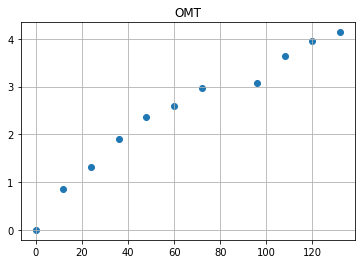

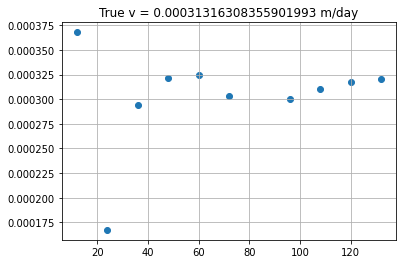

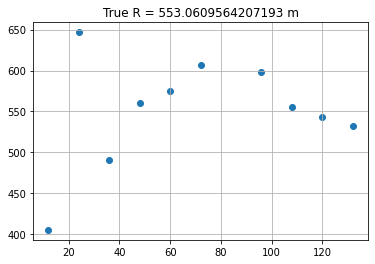

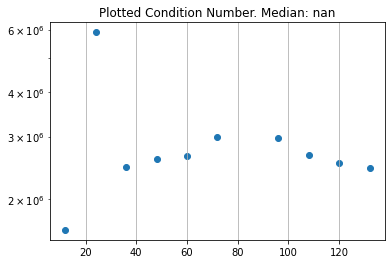

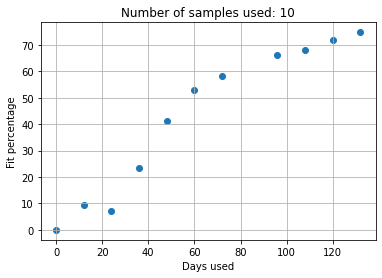

In [9]:
plt.figure()
plt.title(f'OMT')
plt.scatter(delta_days_new,T_save)

plt.grid(True)

plt.figure()
plt.title(f'True v = {v_wink2016_gaus} m/day')
plt.scatter(delta_days_new,v_save)
plt.grid(True)

plt.figure()
plt.title(f'True R = {R_wink2016_gaus} m')
plt.scatter(delta_days_new,R_save)
plt.grid(True)

plt.figure()
plt.title(f'Plotted Condition Number. Median: {np.median(cond_numb_save)}')
plt.scatter(delta_days_new,cond_numb_save)
plt.yscale('log')
plt.grid(True)


plt.figure()
plt.scatter(delta_days_new,fitsave)

plt.ylabel('Fit percentage')
plt.xlabel('Days used')
plt.title(f'Number of samples used: {samples}')
plt.grid(True);

## Conclusions
- Longer timespans gives better solutions
- 

## Applying some tests

### Overall Model Test

$T =\hat{e}^T Q_{yy}^{-1} \hat{e}$ 